In [9]:
# 1. Imports & Config
import pandas as pd
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# --- Add Project Root to Python Path ---
try:
    PROJECT_ROOT = '/content/drive/MyDrive/NFL_Prediction_System'
    if PROJECT_ROOT not in sys.path:
        sys.path.append(str(PROJECT_ROOT))
except:
    pass
from src.utils import config

# --- SETUP OUTPUT DIRECTORY ---
OUTPUT_DIR = config.MODELS_DIR / "baseline" / "VA"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"✅ Setup Complete. Model artifacts will be saved to: {OUTPUT_DIR}")

✅ Setup Complete. Model artifacts will be saved to: /content/drive/MyDrive/NFL_Prediction_System/models/baseline/VA


In [10]:
# 2. Load Master Feature Data
print(f"{'-'*30}\nLoading Master Dataset...")

try:
    # Use tqdm for a visual loading indicator (mostly for aesthetics here as it's fast)
    with tqdm(total=1, desc="Reading Parquet") as pbar:
        features_df = pd.read_parquet(config.FEATURES_DIR / 'features_master_2003_2023.parquet')
        pbar.update(1)

    print(f"✅ Loaded Data: {features_df.shape}")
    print(f"   - Seasons: {features_df['season'].min()} to {features_df['season'].max()}")
    print(f"   - Total Games: {len(features_df)}")

except FileNotFoundError:
    print("❌ Error: Master feature file not found. Run 03_feature_engineering.ipynb.")

------------------------------
Loading Master Dataset...


Reading Parquet:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Loaded Data: (4753, 102)
   - Seasons: 2003 to 2023
   - Total Games: 4753


In [11]:
# 3. Define Features (VEGAS ASSIST)
print(f"{'-'*30}\nDefining Feature Set (VA)...")

TARGET = 'home_win'

# Columns to EXCLUDE (ID cols, Target, and Raw Scores)
# NOTE: We keep 'spread_line' because this is the Vegas Assist model
drop_cols = [
    'game_id', 'season', 'week', 'home_team', 'away_team',
    'home_score', 'away_score', 'home_win', 'home_cover', 'over_hit'
]

# Select Features
feature_cols = [col for col in features_df.columns if col not in drop_cols]

X = features_df[feature_cols].copy().fillna(0)
y = features_df[TARGET].copy()

print(f"✅ Feature Selection Complete:")
print(f"   - Total Features: {len(feature_cols)}")
print(f"   - Vegas Features Included: {'spread_line' in feature_cols}")
print(f"   - Sample Features: {feature_cols[:5]} ...")

------------------------------
Defining Feature Set (VA)...
✅ Feature Selection Complete:
   - Total Features: 94
   - Vegas Features Included: True
   - Sample Features: ['spread_line', 'rest_advantage', 'home_rest', 'away_rest', 'home_off_pass_epa_matchup_roll8'] ...


In [12]:
# 4. Train/Test Split & Scaling
print(f"{'-'*30}\nSplitting & Scaling...")

TEST_SEASON = 2023

# Split
X_train = X[features_df['season'] < TEST_SEASON]
y_train = y[features_df['season'] < TEST_SEASON]
X_test = X[features_df['season'] == TEST_SEASON]
y_test = y[features_df['season'] == TEST_SEASON]

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data Prepared:")
print(f"   - Training Set (2003-2022): {X_train.shape[0]} games")
print(f"   - Test Set (2023): {X_test.shape[0]} games")

------------------------------
Splitting & Scaling...
✅ Data Prepared:
   - Training Set (2003-2022): 4481 games
   - Test Set (2023): 272 games


In [13]:
# 5. Train Model
print(f"{'-'*30}\nTraining Logistic Regression (VA)...")

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)

print("✅ Model Trained Successfully.")

------------------------------
Training Logistic Regression (VA)...
✅ Model Trained Successfully.


------------------------------
Evaluation Results (2023 Season)...
🏆 VA Baseline Accuracy: 67.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       121
           1       0.68      0.76      0.72       151

    accuracy                           0.67       272
   macro avg       0.67      0.66      0.66       272
weighted avg       0.67      0.67      0.67       272



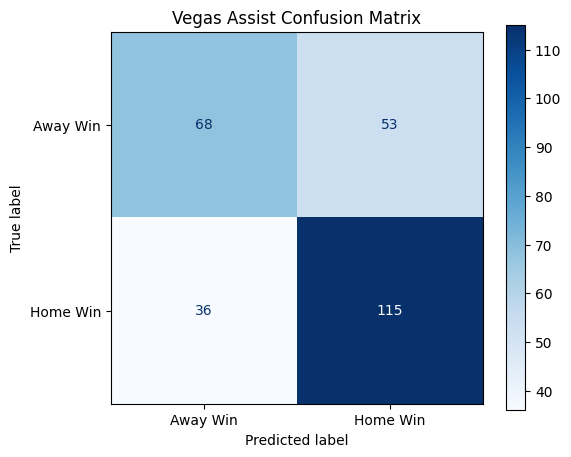

In [14]:
# 6. Evaluate
print(f"{'-'*30}\nEvaluation Results (2023 Season)...")

y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"🏆 VA Baseline Accuracy: {acc * 100:.2f}%")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Away Win', 'Home Win'], cmap='Blues', ax=ax)
plt.title("Vegas Assist Confusion Matrix")
plt.show()

In [15]:
# 7. Save Artifacts
print(f"{'-'*30}\nSaving Model...")

with open(OUTPUT_DIR / "va_baseline_model.pkl", 'wb') as f:
    pickle.dump(model, f)

with open(OUTPUT_DIR / "va_scaler.pkl", 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ VA Model & Scaler saved to:\n   {OUTPUT_DIR}")

------------------------------
Saving Model...
✅ VA Model & Scaler saved to:
   /content/drive/MyDrive/NFL_Prediction_System/models/baseline/VA
